# 19기 Clustering 정규세션 과제

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import *
import warnings
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from collections import Counter

plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')

In [2]:
def cnt_plot(data, col, title):
    plt.rc('font', family='Malgun Gothic')
    plt.rc("axes",unicode_minus=False)
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=40)
    ax=sns.countplot(x=col ,data = data, palette='spring')
    for p in ax.patches:
        ax.annotate("%.0f"%p.get_height(),(p.get_x() + p.get_width()/2, p.get_height()),
                   ha='center', va='center', fontsize=11, color='black', xytext=(0,10),
                   textcoords='offset points')
    plt.title(title)
    plt.show()
    
def cnt_plot2(data, col, title, hue):
    plt.rc('font', family='Malgun Gothic')
    plt.rc("axes",unicode_minus=False)
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=40)
    ax=sns.countplot(x=col ,hue = hue, data = data, palette='spring')
    for p in ax.patches:
        ax.annotate("%.0f"%p.get_height(),(p.get_x() + p.get_width()/2, p.get_height()),
                   ha='center', va='center', fontsize=11, color='black', xytext=(0,10),
                   textcoords='offset points')
    plt.title(title)
    plt.show()

## 0. 데이터 불러오기

In [3]:
import pandas as pd
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. Preprocssing / EDA

- Gender : Gender of the customer
- Age : Age of the customer
- Annual Income : Annual Income of the customee
- Spending Score : Score assigned by the mall based on customer behavior and spending nature

In [4]:
df.isnull().sum() # null 없음

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
df.duplicated().sum() # 중복 없음

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


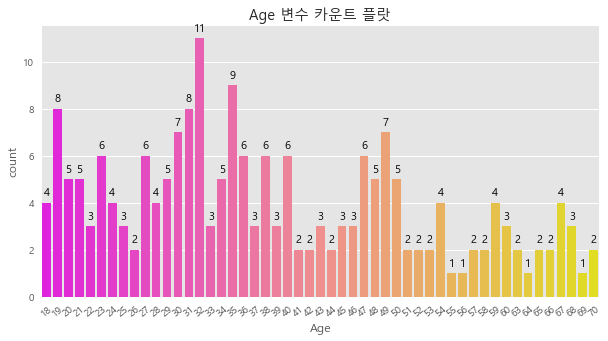

In [10]:
cnt_plot(df,'Age','Age 변수 카운트 플랏')

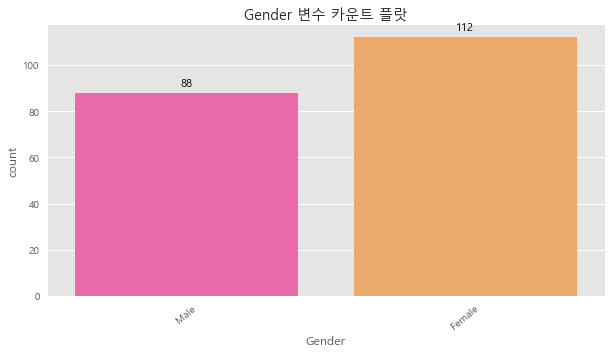

In [11]:
cnt_plot(df,'Gender','Gender 변수 카운트 플랏')

Gender와 Age의 카운트를 확인해 보았습니다. 성별의 경우 Female 이 더 많긴 하지만 큰 차이는 없어 보입니다. 나이의 경우 뚜렷한 특징이 보이지 않아 나이를 묶어준 후 다시 살펴보겠습니다.

In [7]:
df['Age2'] = df['Age']//10*10 # 나이대

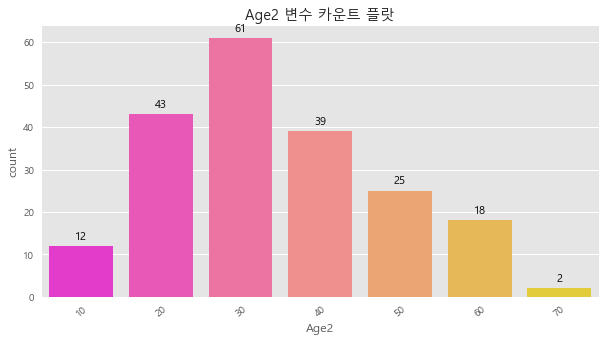

In [13]:
cnt_plot(df,'Age2','Age2 변수 카운트 플랏')

Age 변수에 대해 다시 플랏을 그려 보았을 때, 30 > 20 > 40 순으로 데이터가 존재합니다.

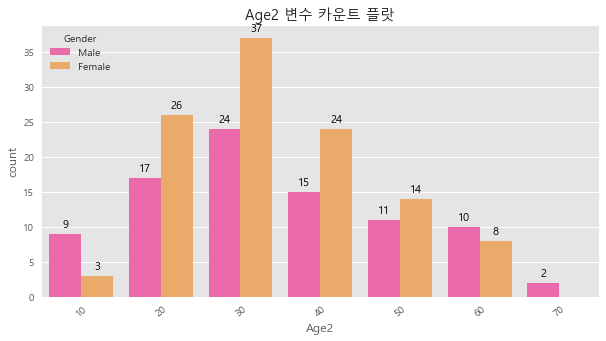

In [14]:
cnt_plot2(df,'Age2','Age2 변수 카운트 플랏','Gender')

10대, 70대를 제외하고는 모두 female인 경우가 더 많습니다.

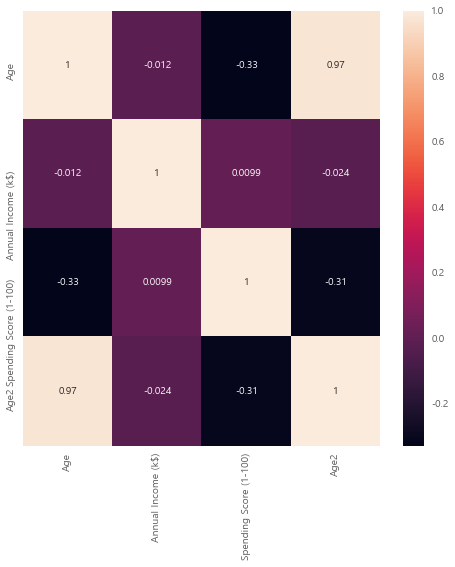

In [15]:
plt.rc('font', family='Malgun Gothic')
plt.rc("axes",unicode_minus=False)
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

상관관계를 살펴보았습니다. AGE와 Spending score의 경우 음의 상관관계를 가지고 있으며 그 외의 변수들은 서로 상관관계가 없어보입니다.

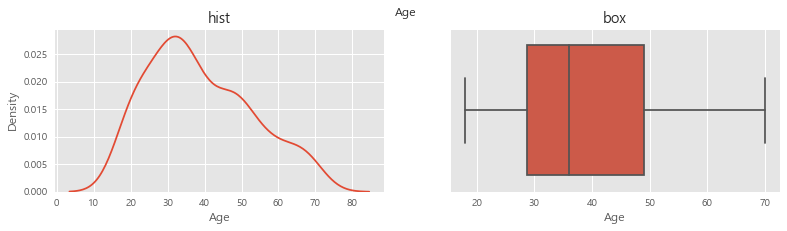

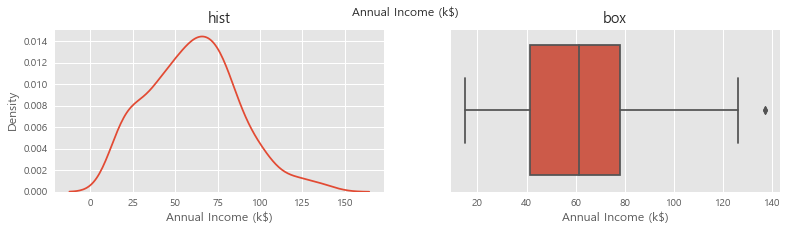

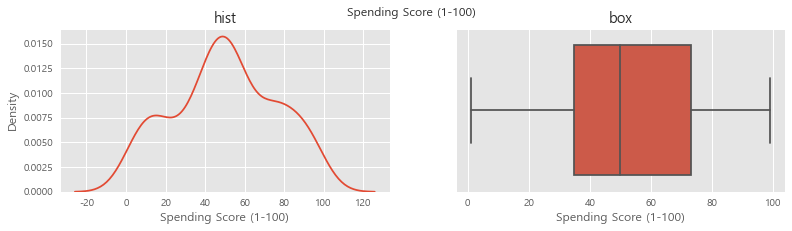

In [16]:
#plot확인
for col in df.columns[1:-1]:
    fig, axes = plt.subplots(1, 2,figsize=(13,3))
    sns.kdeplot(df[col],ax = axes[0])
    sns.boxplot(x=col,data=df,ax = axes[1])
    axes[0].set_title("hist")
    axes[1].set_title("box")
    plt.suptitle(col)

피처들이 비교적 정규분포를 따르고 있으며 신경쓸만한 이상치는 보이지 않습니다.

gender 변수에만 인코딩을 통해 수치형으로 바꿔주겠습니다.

In [8]:
df.loc[(df['Gender']=='Male'), 'Gender'] = 1
df.loc[(df['Gender']=='Female'), 'Gender'] = 0

In [9]:
df.head(3) # 바뀐 데이터 확인

,Gender,Age,Annual Income (k$),Spending Score (1-100),Age2
CustomerID,,,,,
1,1,19,15,39,10
2,1,21,15,81,20
3,0,20,16,6,20


# 2. Clustering

### (1) Hierarchical clustering

계층형 군집을 표현하는 방법으로는 single, complete, average, centroid , ward, diana 방법이 존재하며 linkage 에서 제공하는 single, complete, average, centroid, ward 에 따른 댄드로 그램의 차이를 확인해 보겠습니다.

Text(2000.0, 100, ' 네 개 클러스터')

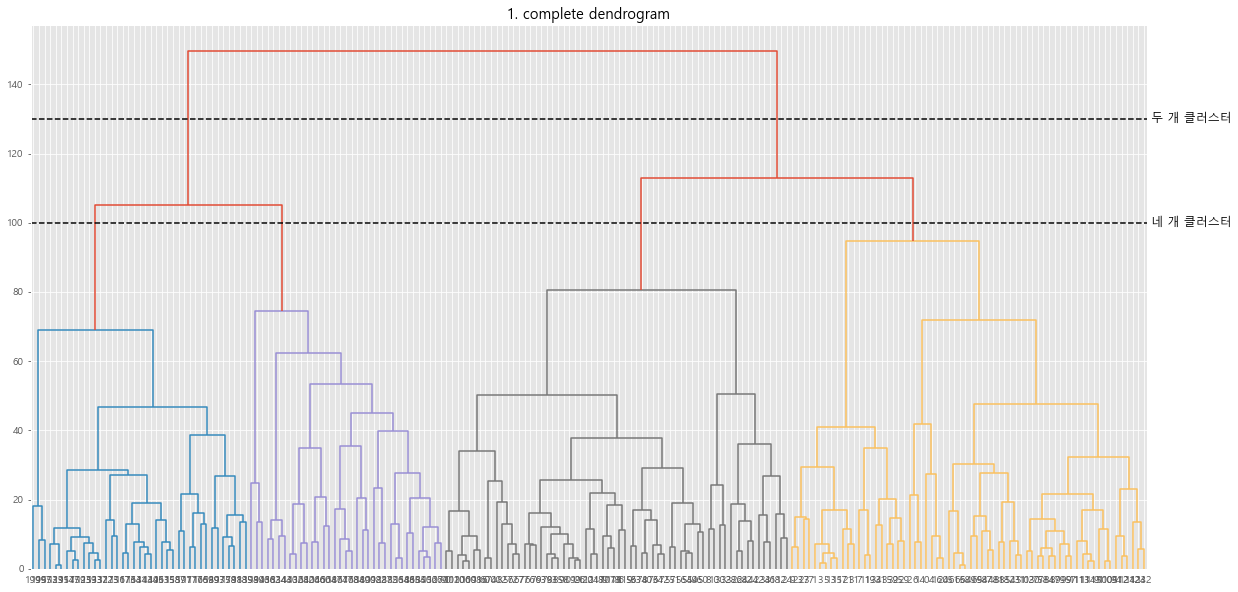

In [26]:
plt.rc('font', family='Malgun Gothic')
cluster = linkage(df,method='complete')
plt.figure(figsize=(20,10))
plt.title("1. complete dendrogram")
dendrogram(cluster, leaf_rotation=0, leaf_font_size =10)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [130, 130], '--', c='k')
ax.plot(bounds, [100, 100], '--', c='k')
ax.text(bounds[1], 130, ' 두 개 클러스터', va='center', fontdict={'size': 12})
ax.text(bounds[1], 100, ' 네 개 클러스터', va='center', fontdict={'size': 12})

Text(2000.0, 300, ' 네 개 클러스터')

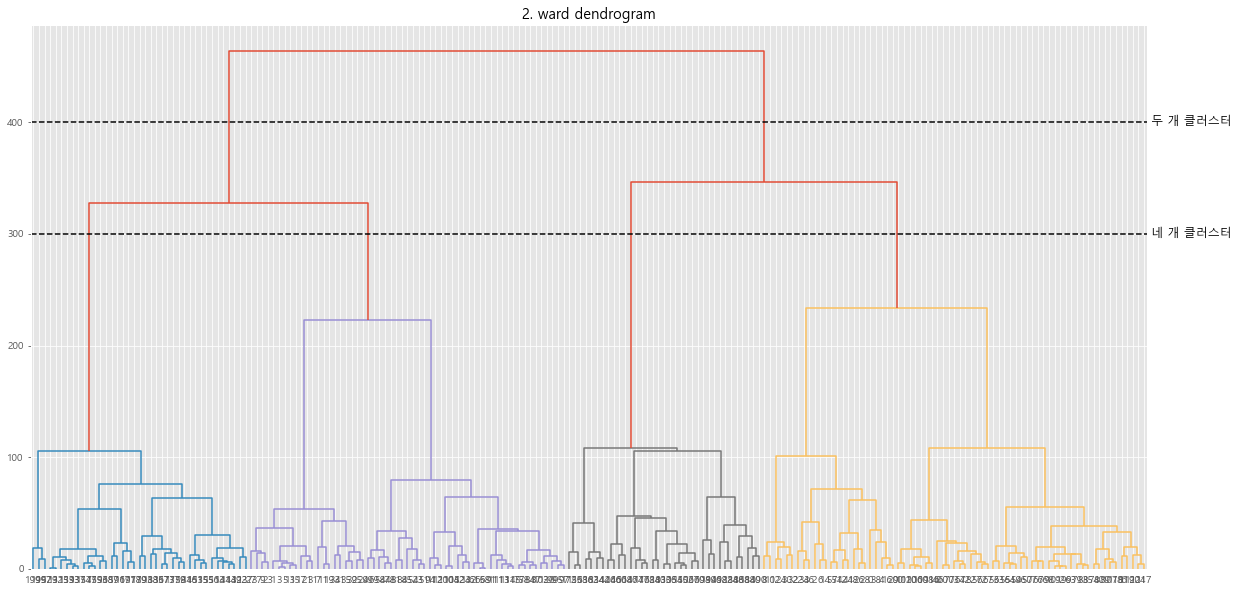

In [28]:
plt.rc('font', family='Malgun Gothic')
cluster = linkage(df,method='ward')
plt.figure(figsize=(20,10))
plt.title("2. ward dendrogram")
dendrogram(cluster, leaf_rotation=0, leaf_font_size =10)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [400, 400], '--', c='k')
ax.plot(bounds, [300, 300], '--', c='k')
ax.text(bounds[1], 400, ' 두 개 클러스터', va='center', fontdict={'size': 12})
ax.text(bounds[1], 300, ' 네 개 클러스터', va='center', fontdict={'size': 12})

Text(2000.0, 20, ' 세 개 클러스터')

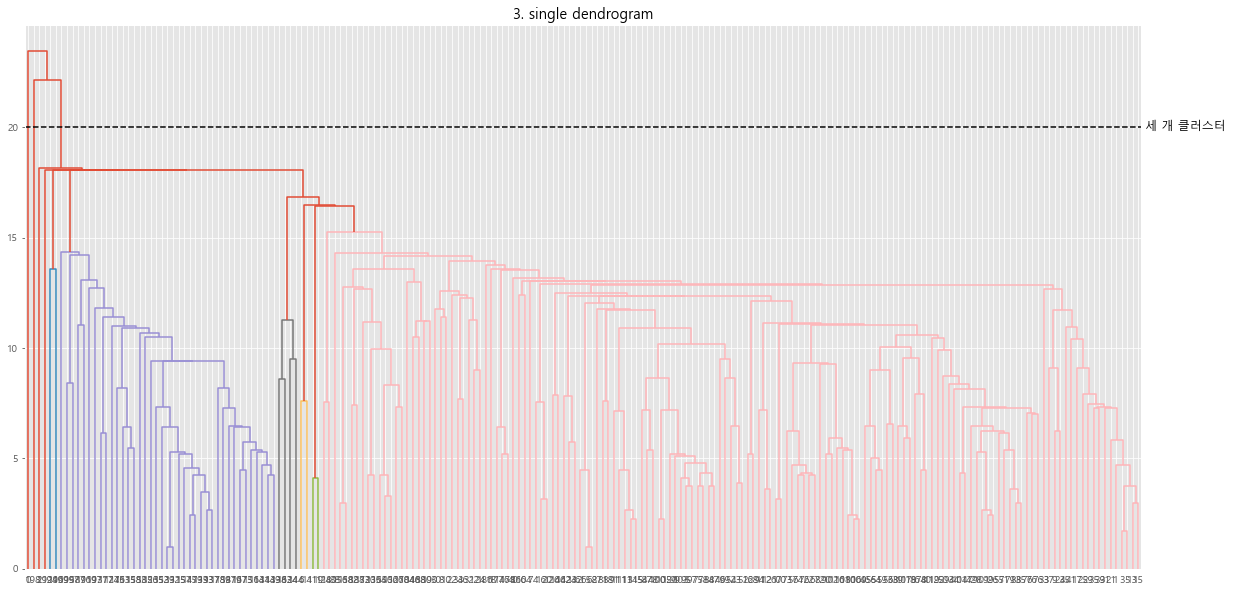

In [31]:
plt.rc('font', family='Malgun Gothic')
cluster = linkage(df,method='single')
plt.figure(figsize=(20,10))
plt.title("3. single dendrogram")
dendrogram(cluster, leaf_rotation=0, leaf_font_size =10)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [20, 20], '--', c='k')
ax.text(bounds[1], 20, ' 세 개 클러스터', va='center', fontdict={'size': 12})

Text(2000.0, 50, ' 세 개 클러스터')

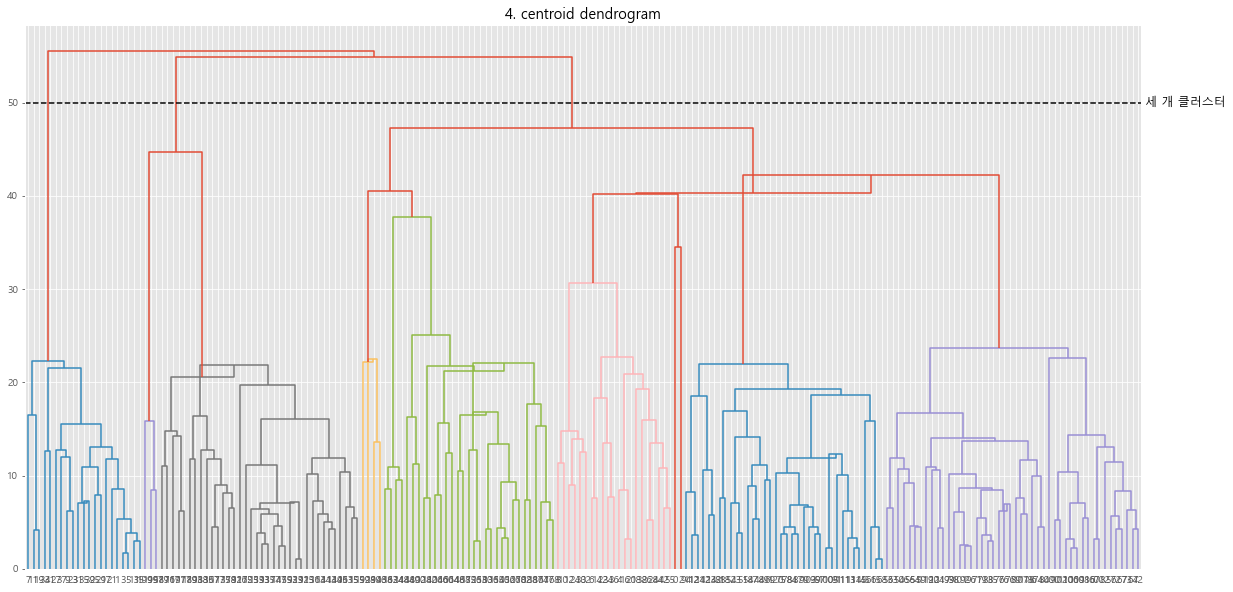

In [32]:
plt.rc('font', family='Malgun Gothic')
cluster = linkage(df,method='centroid')
plt.figure(figsize=(20,10))
plt.title("4. centroid dendrogram")
dendrogram(cluster, leaf_rotation=0, leaf_font_size =10)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [50, 50], '--', c='k')
ax.text(bounds[1], 50, ' 세 개 클러스터', va='center', fontdict={'size': 12})

Text(2000.0, 60, ' 세 개 클러스터')

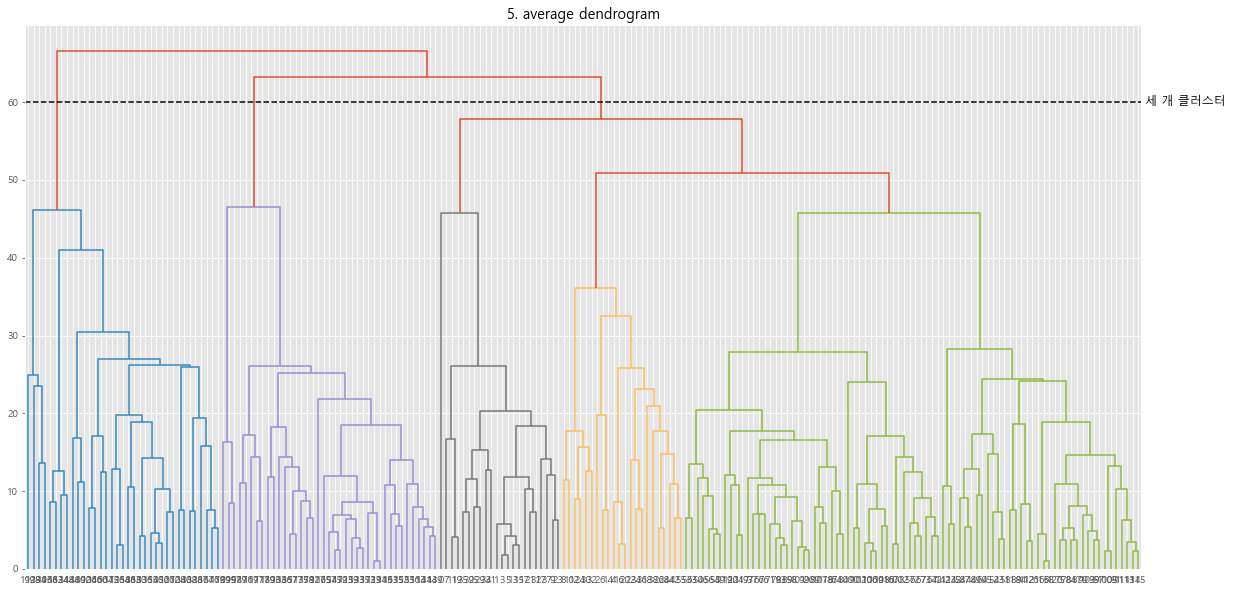

In [34]:
plt.rc('font', family='Malgun Gothic')
cluster = linkage(df,method='average')
plt.figure(figsize=(20,10))
plt.title("5. average dendrogram")
dendrogram(cluster, leaf_rotation=0, leaf_font_size =10)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [60, 60], '--', c='k')
ax.text(bounds[1], 60, ' 세 개 클러스터', va='center', fontdict={'size': 12})

거리 측정 방법에 따라 다르게 군집화가 되는 것이 확인 가능합니다. 하지만 정확하게 어떤 데이터들이 서로 묶였는지 시각적으로 확인하기 어렵다고 생각이 들어서 데이터를 그룹화시킨 후 average측정방법으로 덴드로그램을 한번 더 그려보겠습니다.

In [44]:
dendrogram_df_age = df.groupby(['Age2'])['Spending Score (1-100)'].agg([('median', 'median'),
                                                                        ('mean','mean'),
                                                                        ('max','max'),
                                                                        ('min','min')]).reset_index()

Text(70.0, 45, ' 세 개 클러스터')

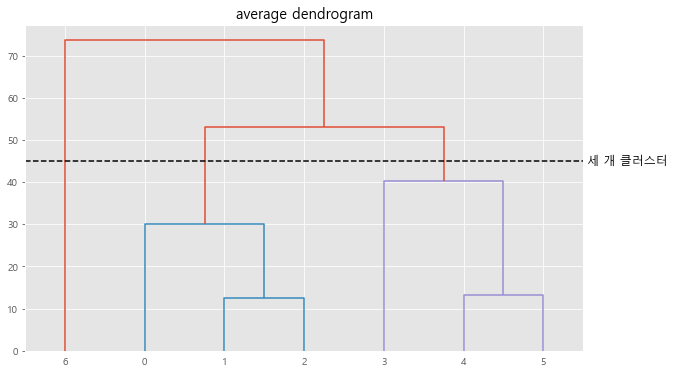

In [55]:
plt.rc('font', family='Malgun Gothic')
cluster = linkage(dendrogram_df_age,method='average')
plt.figure(figsize=(10,6))
plt.title("average dendrogram")
dendrogram(cluster, leaf_rotation=0, leaf_font_size =10)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [45, 45], '--', c='k')
ax.text(bounds[1], 45, ' 세 개 클러스터', va='center', fontdict={'size': 12})

해당 그래프에서 0부터 6까지 숫자는 10대부터 70대 까지를 의미합니다. age2 변수에 따른 Spending Score (1-100) 의 통계량을 그룹화 하여 댄드로그램을 그려본 결과를 3개의 클러스터로 묶어보면 `10대.20대,30대` / `40대,50대,60대` / `70대` 로 군집이 형성됨을 알 수 있습니다.

## (2) K-Means clustering
먼저 Elbow method를 통해 k를 지정해보겠습니다.

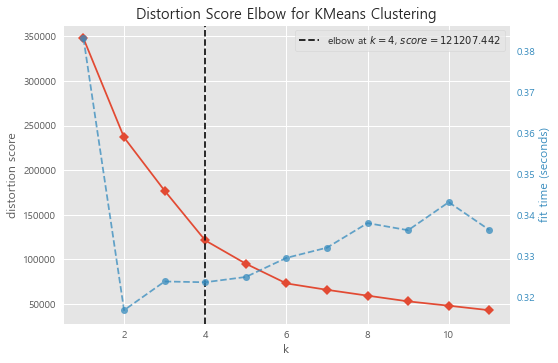

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(df)
visualizer.show()

KElbowVisualizer 결과로 초기 k로 4로 설정하는 것이 괜찮아 보입니다.

이어서 Silhouette coefficient를 통해 초기 k를 확인해보겠습니다.

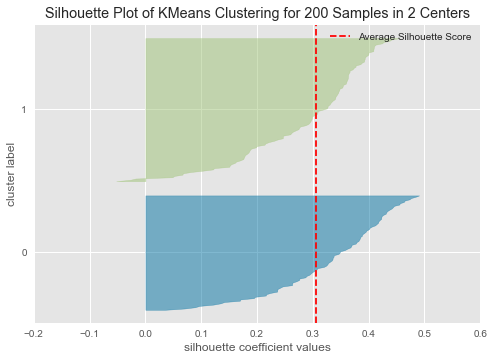

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
# k가 2 인 경우
kmeans_2 = KMeans(n_clusters=2, random_state=111,init='random')
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
visualizer_2.fit(df)      
visualizer_2.show()

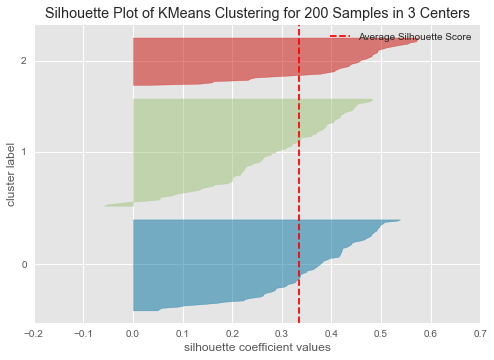

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
# k가 3 인 경우
kmeans_2 = KMeans(n_clusters=3, random_state=111,init='random')
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
visualizer_2.fit(df)      
visualizer_2.show()

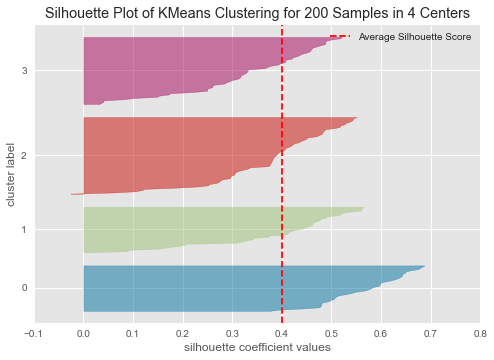

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
# k가 4 인 경우
kmeans_2 = KMeans(n_clusters=4, random_state=111,init='random')
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
visualizer_2.fit(df)      
visualizer_2.show()

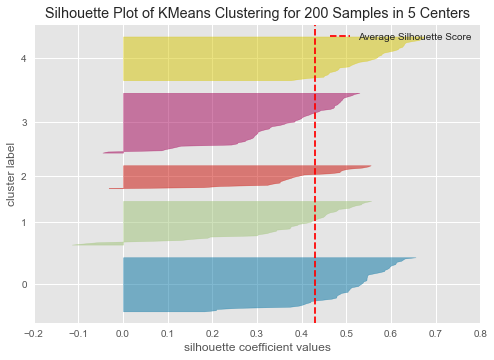

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [14]:
# k가 5 인 경우
kmeans_2 = KMeans(n_clusters=5, random_state=111,init='random')
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
visualizer_2.fit(df)      
visualizer_2.show()

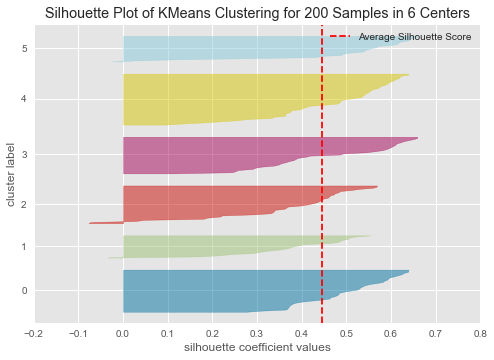

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
# k가 6 인 경우
kmeans_2 = KMeans(n_clusters=6, random_state=111,init='random')
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
visualizer_2.fit(df)      
visualizer_2.show()

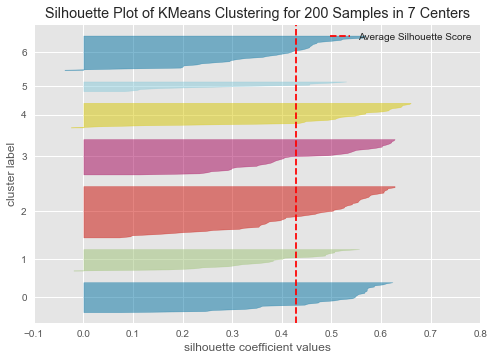

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
# k가 7 인 경우
kmeans_2 = KMeans(n_clusters=7, random_state=111,init='random')
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
visualizer_2.fit(df)      
visualizer_2.show()

y축은 클러스터 ID를, X축은 실루엣 계수를 의미합니다. 빨간 점선은 실루엣 계수의 전체 평균 값을 의미합니다. 실루엣 계수의 전체 평균 값이 크고 클러스터별 실루엣 계수 평균값이 클수록 클러스터링이 잘 되었다고 판단 가능합니다. K가 2인경우에서부터 7인 경우까지 살펴본 결과 스코어가 0.45 정도로 가장 높았던 k=6 인 경우가 가정 적절해보입니다.

# 3. Evaluation

In [17]:
kmeans = KMeans(n_clusters=4, random_state=111)
kmeans.fit(df)
df['labels_4'] = kmeans.predict(df)

In [18]:
kmeans = KMeans(n_clusters=6, random_state=111)
kmeans.fit(df[df.columns[:-1]])
df['labels_6'] = kmeans.predict(df[df.columns[:-1]])

In [19]:
'''
k = 4 인경우
'''
df.groupby(['labels_4'])['Spending Score (1-100)'].agg([('median', 'median'),('min','min'),
                                                        ('mean','mean'),('max','max'),
                                                        ('cnt','count')]).reset_index()

,labels_4,median,min,mean,max,cnt
0,0,56,6,60.298246,99,57
1,1,17,1,19.179487,40,39
2,2,83,63,82.128205,97,39
3,3,46,3,40.800000,60,65


In [20]:
'''
k = 6 인경우
'''
df.groupby(['labels_6'])['Spending Score (1-100)'].agg([('median', 'median'),('min','min'),
                                                        ('mean','mean'),('max','max'),
                                                        ('cnt','count')]).reset_index()

,labels_6,median,min,mean,max,cnt
0,0,83.0,63,82.128205,97,39
1,1,50.0,29,48.823529,60,34
2,2,49.0,35,49.340426,60,47
3,3,76.5,39,76.916667,99,24
4,4,15.0,3,19.380952,40,21
5,5,16.0,1,17.285714,39,35


k가 4인경우와 6인경우 spending score의 통계량을 비교해보면 label6에서 5와 5 그룹은 통계량이 비슷하여 한개의 그룹으로 묶어도 괜찮을 것 같아 보이기 때문에 k를 줄여도 좋을 것 같습니다.